In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt

## Boston数据集

### 一、数据导入

In [3]:
boston = load_boston()

In [4]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

In [5]:
type(boston.data)

numpy.ndarray

In [6]:
type(boston.target)

numpy.ndarray

In [7]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [8]:
data = pd.DataFrame(boston.data)
data.columns = boston.feature_names
data["Price"] = boston.target

In [9]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [10]:
data.shape

(506, 14)

In [11]:
print(data.isna().sum())
print(data.isnull().sum())

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
Price      0
dtype: int64
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
Price      0
dtype: int64


-----------------------------------

### 二、制作训练集和测试集

In [12]:
X, y=data.iloc[:,:-1], data.iloc[:,-1]

In [13]:
matrix = xgb.DMatrix(data=X, label=y)

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1997)

In [15]:
print(X_train.shape)
print(X_test.shape)

(404, 13)
(102, 13)


### 三、Regressor: XGBoost的超参数

learning_rate:学习率(0, 1)

max_depth: Boosting过程中每一个树的最大深度

colsample: 列采样率

subsample: 每棵树的样本采样率

n_estimators: 子树的数量

objective: 树的学习类型   ‘reg: linear’回归模型   ‘reg:logistic':二分类

gamma/alpha: 正则化系数

#### 1. Baseline

In [16]:
model = xgb.XGBRegressor(objective='reg:linear',colsample_bytree=0.7,learning_rate=0.01,max_depth=10,n_estimators=1200)

In [17]:
model.fit(X_train,y_train)

[23:18:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
       early_stopping_rounds=None, enable_categorical=False,
       eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
       importance_type=None, interaction_constraints='',
       learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
       max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
       missing=nan, monotone_constraints='()', n_estimators=1200, n_jobs=0,
       num_parallel_tree=1, objective='reg:linear', predictor='auto',
       random_state=0, reg_alpha=0, reg_lambda=1,
       sampling_method='uniform', scale_pos_weight=1, subsample=1,
       tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
preds = model.predict(X_test)

In [19]:
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
loggedrmse = np.sqrt(mean_squared_error(np.log(y_test), np.log(preds)))
print(mse)
print(rmse)
print(loggedrmse)

7.7373724319057136
2.781613278639882
0.1308342635874314


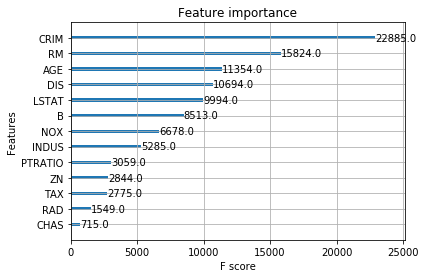

In [20]:
xgb.plot_importance(model)
plt.show()

#### 2. 调参

n_estimators可以调大，但是过大可能会造成过拟合

colsample_bytree可以适当放小，但不能太小。太大会过拟合，太小会欠拟合

learning_rate可以适当放小，在步长max_depth很大的情况下

#### 3. 交叉验证

1.数据有限

2.发挥数据有效率

3.把数据拆成k份

4.各自把其中k-1份进行训练，剩下1份用来测评

5.评测的分值等于所有测评值的平均

6.不同的模型会提供不同的合并方法，会将所有的k个子模型进行合并